## An Analysis of crime in NYC



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
%pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

#from shapely.geometry import Point


Note: you may need to restart the kernel to use updated packages.


In [2]:
arrests = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/NYPD_Arrest_Data__Year_to_Date__20231017.csv')
cd = gpd.read_file('/Users/abbascauser/Documents/Data Science/Capstone/nycd_23b/nycd.shp') #read in the shapefile with the Community District BORO Codes
demo_age = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/cd_demo_age_gender.csv')
demo_econ = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/cd_demo_race_economics.csv')
demo_snap = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/2017-18__-_2021-22_Demographic_Snapshot_20231017.csv')
financial = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/Neighborhood_Financial_Health_Digital_Mapping_and_Data_Tool_20231017.csv')

In [3]:
cd.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,263238742,02/08/2023,380.0,"ROBBERY,CAR JACKING",105.0,ROBBERY,PL 1601003,F,K,62,0,25-44,F,WHITE,989904,156928,40.597407,-73.979638,POINT (-73.979638 40.597407)
1,265590985,03/24/2023,155.0,RAPE 2,104.0,RAPE,PL 1303001,F,S,120,0,18-24,M,BLACK,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691)
2,265798132,03/28/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,S,120,0,25-44,M,BLACK,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691)
3,269233687,06/02/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,Q,110,0,25-44,M,WHITE HISPANIC,1019164,210169,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841)
4,270519574,06/28/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,84,0,25-44,M,BLACK HISPANIC,988902,192641,40.695439,-73.983225,POINT (-73.9832253756043 40.6954388081238)


In [5]:
arrests.shape

(112571, 19)

In [6]:
# Mapping the arrests locations within community districts so we can port over demographic data. This will be used in the next round

gdf = gpd.GeoDataFrame(arrests, geometry=gpd.points_from_xy(arrests.X_COORD_CD, arrests.Y_COORD_CD, crs="EPSG:2263"))
mapped_data = gpd.sjoin(gdf, cd, how='left', op="within")

/Users/abbascauser/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
mapped_data

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column,geometry,index_right,BoroCD,Shape_Leng,Shape_Area
0,263238742,02/08/2023,380.0,"ROBBERY,CAR JACKING",105.0,ROBBERY,PL 1601003,F,K,62,...,989904,156928,40.597407,-73.979638,POINT (-73.979638 40.597407),POINT (989904.000 156928.000),12.0,311.0,51534.144461,1.032083e+08
1,265590985,03/24/2023,155.0,RAPE 2,104.0,RAPE,PL 1303001,F,S,120,...,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691),POINT (962873.000 174172.000),3.0,501.0,153751.224769,3.772325e+08
2,265798132,03/28/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,S,120,...,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691),POINT (962873.000 174172.000),3.0,501.0,153751.224769,3.772325e+08
3,269233687,06/02/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,Q,110,...,1019164,210169,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),POINT (1019164.000 210169.000),45.0,404.0,37018.384609,6.573961e+07
4,270519574,06/28/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,84,...,988902,192641,40.695439,-73.983225,POINT (-73.9832253756043 40.6954388081238),POINT (988902.000 192641.000),47.0,302.0,74158.876043,7.933825e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112566,267861068,05/07/2023,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL05110MU,M,Q,113,...,1046315,187088,40.679981,-73.776234,POINT (-73.7762339071953 40.6799807384666),POINT (1046315.000 187088.000),31.0,412.0,65926.092997,2.673326e+08
112567,270481110,06/27/2023,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,K,79,...,999872,187803,40.682141,-73.943673,POINT (-73.943673 40.682141),POINT (999872.000 187803.000),48.0,303.0,36213.675388,7.946168e+07
112568,267833542,05/06/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601502,F,B,43,...,1019852,241853,40.830435,-73.871349,POINT (-73.871349 40.830435),POINT (1019852.000 241853.000),43.0,209.0,62243.635444,1.142848e+08
112569,268911088,05/27/2023,494.0,"STOLEN PROPERTY 2,1,POSSESSION",111.0,POSSESSION OF STOLEN PROPERTY,PL 1654502,F,B,46,...,1011750,250274,40.853578,-73.900591,POINT (-73.900591 40.853578),POINT (1011750.000 250274.000),9.0,205.0,29443.048181,3.831698e+07


In [8]:
# Converting arrest date to datetime

arrests['ARREST_DATE'] = pd.to_datetime(arrests['ARREST_DATE'])

In [9]:
# Adding a new column for day of week based on arrest date

arrests['DOW'] = arrests['ARREST_DATE'].dt.strftime("%a")

In [10]:
arrests['OFNS_DESC'].value_counts()

ASSAULT 3 & RELATED OFFENSES      16619
PETIT LARCENY                     12070
FELONY ASSAULT                    10474
DANGEROUS DRUGS                    7530
MISCELLANEOUS PENAL LAW            7327
                                  ...  
PARKING OFFENSES                      3
FELONY SEX CRIMES                     2
DISRUPTION OF A RELIGIOUS SERV        2
UNLAWFUL POSS. WEAP. ON SCHOOL        1
ADMINISTRATIVE CODES                  1
Name: OFNS_DESC, Length: 63, dtype: int64

In [11]:
cd_profile = pd.read_csv('/Users/abbascauser/Downloads/cd_demo_race_economics.csv')
cd_profile.loc[cd_profile['cd_number']==308,:]

,cd_name,cd_number,borough,pct_foreign_born,moe_foreign_born,lep_rate,moe_lep_rate,pct_white_nh,pct_black_nh,pct_asian_nh,...,pct_hh_rent_burd,moe_hh_rent_burd,pct_bach_deg,moe_bach_deg,unemployment,moe_unemployment,mean_commute,moe_mean_commute,crime_count,crime_per_1000
19,Brooklyn Community District 8,308,Brooklyn,29.5,1.2,6.7,0.7,27.4,52.8,4.1,...,41.8,1.8,45.1,1.2,4.6,0.5,41.2,1.5,1140,9.4


In [12]:
comm_dist = pd.read_csv('/Users/abbascauser/Downloads/nycd.csv')
comm_dist

,the_geom,BoroCD,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.95829216807752 40.67983113...,308,38232.886649,4.560379e+07
1,MULTIPOLYGON (((-73.9097168492596 40.565287425...,414,210918.174933,1.955766e+08
2,MULTIPOLYGON (((-73.90268810116362 40.84458147...,204,31358.450463,5.552214e+07
3,MULTIPOLYGON (((-74.15945602438066 40.64144833...,501,153751.224769,3.772325e+08
4,MULTIPOLYGON (((-73.85254750230214 40.76006981...,407,145357.138028,3.282876e+08
...,...,...,...,...
66,MULTIPOLYGON (((-73.9123679028881 40.584526174...,356,255184.045964,1.302063e+08
67,MULTIPOLYGON (((-73.98877931684075 40.73396539...,103,30507.707496,4.687392e+07
68,MULTIPOLYGON (((-73.92405909736993 40.71411156...,301,69196.767286,1.316952e+08
69,MULTIPOLYGON (((-73.98017161103716 40.66115465...,307,87448.443796,1.041264e+08


In [13]:
arrests['OFNS_DESC'].value_counts()

ASSAULT 3 & RELATED OFFENSES      16619
PETIT LARCENY                     12070
FELONY ASSAULT                    10474
DANGEROUS DRUGS                    7530
MISCELLANEOUS PENAL LAW            7327
                                  ...  
PARKING OFFENSES                      3
FELONY SEX CRIMES                     2
DISRUPTION OF A RELIGIOUS SERV        2
UNLAWFUL POSS. WEAP. ON SCHOOL        1
ADMINISTRATIVE CODES                  1
Name: OFNS_DESC, Length: 63, dtype: int64

In [14]:
# Creating a new column for offense type

arrests['OFFENSE_TYPE'] = arrests['OFNS_DESC']

In [15]:
# Creating new buckets for each of the offense type to reduce its complexity

assault = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['assault','murder']),case=False,na=False)==True]
larceny = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['larceny','thef','stolen','steal']),case=False,na=False)==True]
burglary = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['burglar','trespass']),case=False,na=False)==True]
substance = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['drug','cannabis','alcohol']),case=False,na=False)==True]
motor = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['traffic','driving','car','vehicle']),case=False,na=False)==True]
sex_crimes = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['rape','sex','prostitution']),case=False,na=False)==True]
fraud = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['fraud','forgery']),case=False,na=False)==True]

In [16]:
assault['OFFENSE_TYPE'].value_counts()

ASSAULT 3 & RELATED OFFENSES      16619
FELONY ASSAULT                    10474
MURDER & NON-NEGL. MANSLAUGHTE      948
Name: OFFENSE_TYPE, dtype: int64

In [17]:
larceny['OFFENSE_TYPE'].value_counts()

PETIT LARCENY                     12070
GRAND LARCENY                      5074
OTHER OFFENSES RELATED TO THEF     2664
POSSESSION OF STOLEN PROPERTY      1814
GRAND LARCENY OF MOTOR VEHICLE      870
THEFT-FRAUD                         119
THEFT OF SERVICES                    70
Name: OFFENSE_TYPE, dtype: int64

In [18]:
burglary['OFFENSE_TYPE'].value_counts()

BURGLARY             3173
CRIMINAL TRESPASS    1000
BURGLAR'S TOOLS       344
Name: OFFENSE_TYPE, dtype: int64

In [19]:
substance['OFFENSE_TYPE'].value_counts()

DANGEROUS DRUGS                   7530
CANNABIS RELATED OFFENSES          126
ALCOHOLIC BEVERAGE CONTROL LAW      96
Name: OFFENSE_TYPE, dtype: int64

In [20]:
motor['OFFENSE_TYPE'].value_counts()

VEHICLE AND TRAFFIC LAWS          6612
INTOXICATED & IMPAIRED DRIVING    1331
OTHER TRAFFIC INFRACTION          1137
GRAND LARCENY OF MOTOR VEHICLE     870
UNAUTHORIZED USE OF A VEHICLE      325
INTOXICATED/IMPAIRED DRIVING       207
Name: OFFENSE_TYPE, dtype: int64

In [21]:
sex_crimes['OFFENSE_TYPE'].value_counts()

SEX CRIMES                         2600
RAPE                                359
PROSTITUTION & RELATED OFFENSES     126
FELONY SEX CRIMES                     2
Name: OFFENSE_TYPE, dtype: int64

In [22]:
fraud['OFFENSE_TYPE'].value_counts()

OFFENSES INVOLVING FRAUD    2645
FORGERY                     1755
FRAUDS                       354
THEFT-FRAUD                  119
FRAUDULENT ACCOSTING          34
Name: OFFENSE_TYPE, dtype: int64

In [23]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column,DOW,OFFENSE_TYPE
0,263238742,2023-02-08,380.0,"ROBBERY,CAR JACKING",105.0,ROBBERY,PL 1601003,F,K,62,...,25-44,F,WHITE,989904,156928,40.597407,-73.979638,POINT (-73.979638 40.597407),Wed,ROBBERY
1,265590985,2023-03-24,155.0,RAPE 2,104.0,RAPE,PL 1303001,F,S,120,...,18-24,M,BLACK,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691),Fri,RAPE
2,265798132,2023-03-28,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,S,120,...,25-44,M,BLACK,962873,174172,40.644721,-74.077033,POINT (-74.0770327198983 40.6447209438691),Tue,RAPE
3,269233687,2023-06-02,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,Q,110,...,25-44,M,WHITE HISPANIC,1019164,210169,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),Fri,RAPE
4,270519574,2023-06-28,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,84,...,25-44,M,BLACK HISPANIC,988902,192641,40.695439,-73.983225,POINT (-73.9832253756043 40.6954388081238),Wed,RAPE


In [24]:
# Mapping most of the offense types to smaller buckets

offense_mapping = {
    'ASSAULT 3 & RELATED OFFENSES': 'ASSAULT',
    'FELONY ASSAULT': 'ASSAULT',
    'MURDER & NON-NEGL. MANSLAUGHTE': 'ASSAULT',
    'JOSTLING': 'ASSAULT',
    'PETIT LARCENY': 'LARCENY',
    'GRAND LARCENY': 'LARCENY',
    'OTHER OFFENSES RELATED TO THEF': 'LARCENY',
    'POSSESSION OF STOLEN PROPERTY': 'LARCENY',
    'GRAND LARCENY OF MOTOR VEHICLE': 'LARCENY',
    'THEFT-FRAUD': 'LARCENY',
    'THEFT OF SERVICES': 'LARCENY',
    'THEFT-FRAUD': 'LARCENY',
    'CRIMINAL TRESPASS': 'BURGLARY',
    'BURGLAR\'S TOOLS': 'BURGLARY',
    'DANGEROUS DRUGS': 'SUBSTANCES',
    'CANNABIS RELATED OFFENSES': 'SUBSTANCES',
    'ALCOHOLIC BEVERAGE CONTROL LAW': 'SUBSTANCES',
    'INTOXICATED & IMPAIRED DRIVING': 'SUBSTANCES',
    'INTOXICATED/IMPAIRED DRIVING': 'SUBSTANCES',
    'VEHICLE AND TRAFFIC LAWS': 'MOTOR',
    'PARKING OFFENSES': 'MOTOR',
    'OTHER TRAFFIC INFRACTION': 'MOTOR',
    'UNAUTHORIZED USE OF A VEHICLE': 'MOTOR',
    'PROSTITUTION & RELATED OFFENSES': 'SEX CRIMES',
    'FELONY SEX CRIMES': 'SEX CRIMES',
    'RAPE': 'SEX CRIMES',
    'HARRASSMENT 2': 'SEX CRIMES',
    'HARRASSMENT 2': 'SEX CRIMES',
    'OFFENSES INVOLVING FRAUD': 'FRAUD',
    'FORGERY': 'FRAUD',
    'FRAUDS': 'FRAUD',
    'THEFT-FRAUD': 'FRAUD',
    'FRAUDULENT ACCOSTING': 'FRAUD',
    'DANGEROUS WEAPONS': 'ARMS',
    'ARSON': 'ARMS',
    'UNLAWFUL POSS. WEAP. ON SCHOOL': 'ARMS',
    'KIDNAPPING & RELATED OFFENSES': 'KIDNAPPING'
}

In [25]:
arrests['OFFENSE_TYPE'] = arrests['OFFENSE_TYPE'].replace(offense_mapping)


In [26]:
arrests['OFFENSE_TYPE'].value_counts()

ASSAULT                                 28083
LARCENY                                 22562
SUBSTANCES                               9290
MOTOR                                    8077
MISCELLANEOUS PENAL LAW                  7327
CRIMINAL MISCHIEF & RELATED OF           5515
ROBBERY                                  5368
FRAUD                                    4907
ARMS                                     4728
BURGLARY                                 4517
OFFENSES AGAINST PUBLIC ADMINI           3248
SEX CRIMES                               3134
OFF. AGNST PUB ORD SENSBLTY &            2034
FOR OTHER AUTHORITIES                     846
OFFENSES AGAINST THE PERSON               714
NYS LAWS-UNCLASSIFIED FELONY              590
(null)                                    466
OTHER STATE LAWS                          406
GAMBLING                                  195
OTHER STATE LAWS (NON PENAL LA            175
ADMINISTRATIVE CODE                        93
KIDNAPPING                        

In [27]:
offenses = arrests['OFFENSE_TYPE'].unique()
offenses

array(['ROBBERY', 'SEX CRIMES', 'ASSAULT', 'ARMS', '(null)', 'BURGLARY',
       'LARCENY', 'CRIMINAL MISCHIEF & RELATED OF',
       'OFF. AGNST PUB ORD SENSBLTY &', 'MOTOR',
       'MISCELLANEOUS PENAL LAW', 'SUBSTANCES', 'FRAUD',
       'OFFENSES AGAINST PUBLIC ADMINI', 'NYS LAWS-UNCLASSIFIED FELONY',
       'OTHER STATE LAWS (NON PENAL LA', 'OFFENSES AGAINST THE PERSON',
       'FOR OTHER AUTHORITIES', 'ENDAN WELFARE INCOMP',
       'OFFENSES AGAINST PUBLIC SAFETY', 'ANTICIPATORY OFFENSES',
       'OTHER STATE LAWS', 'ADMINISTRATIVE CODE', 'GAMBLING',
       'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'OFFENSES RELATED TO CHILDREN', 'DISORDERLY CONDUCT',
       'HOMICIDE-NEGLIGENT,UNCLASSIFIE', 'KIDNAPPING', 'ESCAPE 3',
       'ADMINISTRATIVE CODES', 'CHILD ABANDONMENT/NON SUPPORT',
       'MOVING INFRACTIONS', 'OTHER STATE LAWS (NON PENAL LAW)',
       'DISRUPTION OF A RELIGIOUS SERV'], dtype=object)

In [28]:
# For further imputation, isolating only those offenses that were >80% felonies

felonies = []

for i in offenses:
    if ((len(arrests[(arrests['OFFENSE_TYPE']==str(i)) & (arrests['LAW_CAT_CD']==str('F'))])) / (len(arrests[(arrests['OFFENSE_TYPE']==str(i))]))>0.8):
        felonies.append(i)

felonies

['ROBBERY',
 'MISCELLANEOUS PENAL LAW',
 'NYS LAWS-UNCLASSIFIED FELONY',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
 'KIDNAPPING',
 'CHILD ABANDONMENT/NON SUPPORT']

In [29]:
felony_mapping = {
    'MISCELLANEOUS PENAL LAW': 'OTHER FELONY',
    'NYS LAWS-UNCLASSIFIED FELONY': 'OTHER FELONY',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 'OTHER FELONY',
    'CHILD ABANDONMENT/NON SUPPORT': 'OTHER FELONY',
    'OFFENSES RELATED TO CHILDREN': 'OTHER FELONY'}

arrests['OFFENSE_TYPE'] = arrests['OFFENSE_TYPE'].replace(felony_mapping)
arrests['OFFENSE_TYPE'].value_counts()

ASSAULT                                 28083
LARCENY                                 22562
SUBSTANCES                               9290
MOTOR                                    8077
OTHER FELONY                             7986
CRIMINAL MISCHIEF & RELATED OF           5515
ROBBERY                                  5368
FRAUD                                    4907
ARMS                                     4728
BURGLARY                                 4517
OFFENSES AGAINST PUBLIC ADMINI           3248
SEX CRIMES                               3134
OFF. AGNST PUB ORD SENSBLTY &            2034
FOR OTHER AUTHORITIES                     846
OFFENSES AGAINST THE PERSON               714
(null)                                    466
OTHER STATE LAWS                          406
GAMBLING                                  195
OTHER STATE LAWS (NON PENAL LA            175
ADMINISTRATIVE CODE                        93
KIDNAPPING                                 58
OFFENSES AGAINST PUBLIC SAFETY    

In [30]:
# For further imputation, isolating only those offenses that were >90% felonies

other_large = []

for i in offenses:
    if len(arrests[(arrests['OFFENSE_TYPE']==str(i))])>100:
        other_large.append(i)

other_large

['ROBBERY',
 'SEX CRIMES',
 'ASSAULT',
 'ARMS',
 '(null)',
 'BURGLARY',
 'LARCENY',
 'CRIMINAL MISCHIEF & RELATED OF',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'MOTOR',
 'SUBSTANCES',
 'FRAUD',
 'OFFENSES AGAINST PUBLIC ADMINI',
 'OTHER STATE LAWS (NON PENAL LA',
 'OFFENSES AGAINST THE PERSON',
 'FOR OTHER AUTHORITIES',
 'OTHER STATE LAWS',
 'GAMBLING']

In [31]:
other_large_mapping = {
    'CRIMINAL MISCHIEF & RELATED OF': 'OTHER LARGE',
    'OFF. AGNST PUB ORD SENSBLTY &': 'OTHER LARGE',
    'OFFENSES AGAINST PUBLIC ADMINI': 'OTHER LARGE',
    'OTHER STATE LAWS (NON PENAL LA': 'OTHER LARGE',
    'OFFENSES AGAINST THE PERSON': 'OTHER LARGE',
    'FOR OTHER AUTHORITIES': 'OTHER LARGE',
    'OTHER STATE LAWS': 'OTHER LARGE',
    'GAMBLING': 'OTHER LARGE'
}

arrests['OFFENSE_TYPE'] = arrests['OFFENSE_TYPE'].replace(other_large_mapping)
arrests['OFFENSE_TYPE'].value_counts()

ASSAULT                                 28083
LARCENY                                 22562
OTHER LARGE                             13133
SUBSTANCES                               9290
MOTOR                                    8077
OTHER FELONY                             7986
ROBBERY                                  5368
FRAUD                                    4907
ARMS                                     4728
BURGLARY                                 4517
SEX CRIMES                               3134
(null)                                    466
ADMINISTRATIVE CODE                        93
KIDNAPPING                                 58
OFFENSES AGAINST PUBLIC SAFETY             41
ENDAN WELFARE INCOMP                       36
AGRICULTURE & MRKTS LAW-UNCLASSIFIED       32
DISORDERLY CONDUCT                         22
MOVING INFRACTIONS                         14
ANTICIPATORY OFFENSES                      11
OTHER STATE LAWS (NON PENAL LAW)            6
ESCAPE 3                          

In [32]:
# The remaindeer going in another bucket

other_small_mapping = {
    '(null)': 'OTHER SMALL',
    'ADMINISTRATIVE CODE': 'OTHER SMALL',
    'OFFENSES AGAINST PUBLIC SAFETY': 'OTHER SMALL',
    'ENDAN WELFARE INCOMP': 'OTHER SMALL',
    'AGRICULTURE & MRKTS LAW-UNCLASSIFIED': 'OTHER SMALL',
    'DISORDERLY CONDUCT': 'OTHER SMALL',
    'MOVING INFRACTIONS': 'OTHER SMALL',
    'ANTICIPATORY OFFENSES': 'OTHER SMALL',
    'OTHER STATE LAWS (NON PENAL LAW)': 'OTHER SMALL',
    'ESCAPE 3': 'OTHER SMALL',
    'DISRUPTION OF A RELIGIOUS SERV': 'OTHER SMALL',
    'ADMINISTRATIVE CODES': 'OTHER SMALL',
}

arrests['OFFENSE_TYPE'] = arrests['OFFENSE_TYPE'].replace(other_small_mapping)


<Axes: >

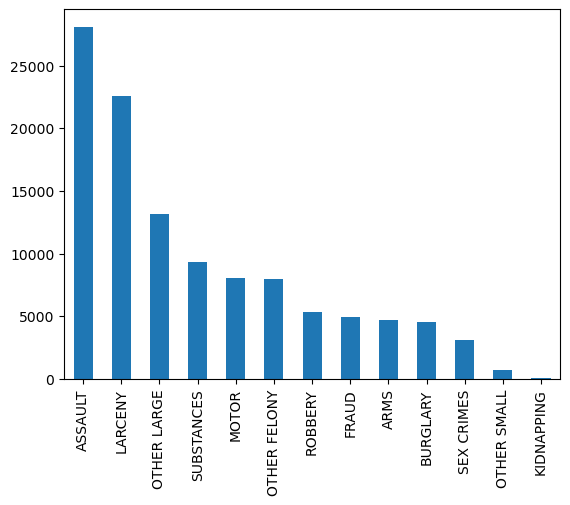

In [33]:
arrests['OFFENSE_TYPE'].value_counts().plot(kind="bar")

<Axes: ylabel='OFFENSE_TYPE'>

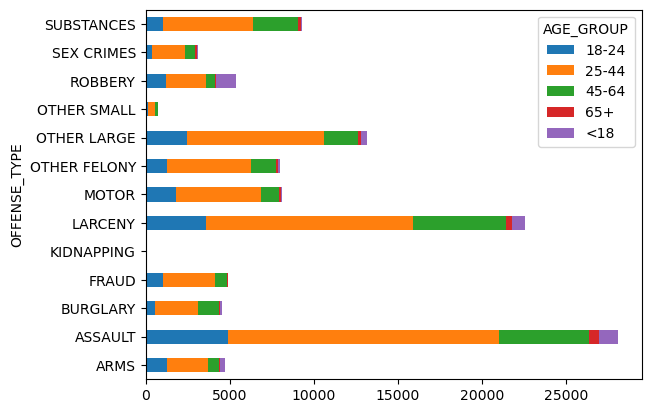

In [34]:
# Breakdown of age group by offense type

arrests.groupby('OFFENSE_TYPE')['AGE_GROUP'].value_counts().unstack().plot(kind='barh', stacked=True)

In [35]:
# Dropping race to remove as an indicator

arrests = arrests.drop('PERP_RACE',axis=1)

In [36]:
arrest_columns = arrests.columns.to_list()

In [37]:
# Dertermining the unique values of several columns to see if its worth dummying

for i in arrest_columns:
    print(f"{i}: {len(arrests[i].unique())}")

ARREST_KEY: 112571
ARREST_DATE: 181
PD_CD: 244
PD_DESC: 233
KY_CD: 67
OFNS_DESC: 63
LAW_CODE: 923
LAW_CAT_CD: 6
ARREST_BORO: 5
ARREST_PRECINCT: 77
JURISDICTION_CODE: 22
AGE_GROUP: 5
PERP_SEX: 3
X_COORD_CD: 22160
Y_COORD_CD: 23202
Latitude: 26457
Longitude: 26469
New Georeferenced Column: 26963
DOW: 7
OFFENSE_TYPE: 13


In [38]:
# Dropping all unnecessary columns with greater than 15 unique values.

arrests_clean = arrests.copy()

for i in arrest_columns:
    if len(arrests_clean[i].unique()) > 15:
        del arrests_clean[i]

arrests_clean.shape

(112571, 6)

In [39]:
# Split into X and y and make X into dummies to prepare for model


X = arrests_clean.drop('OFFENSE_TYPE', axis=1)
y = arrests_clean['OFFENSE_TYPE']

X = pd.get_dummies(X)

len(X.columns)

25

<Axes: >

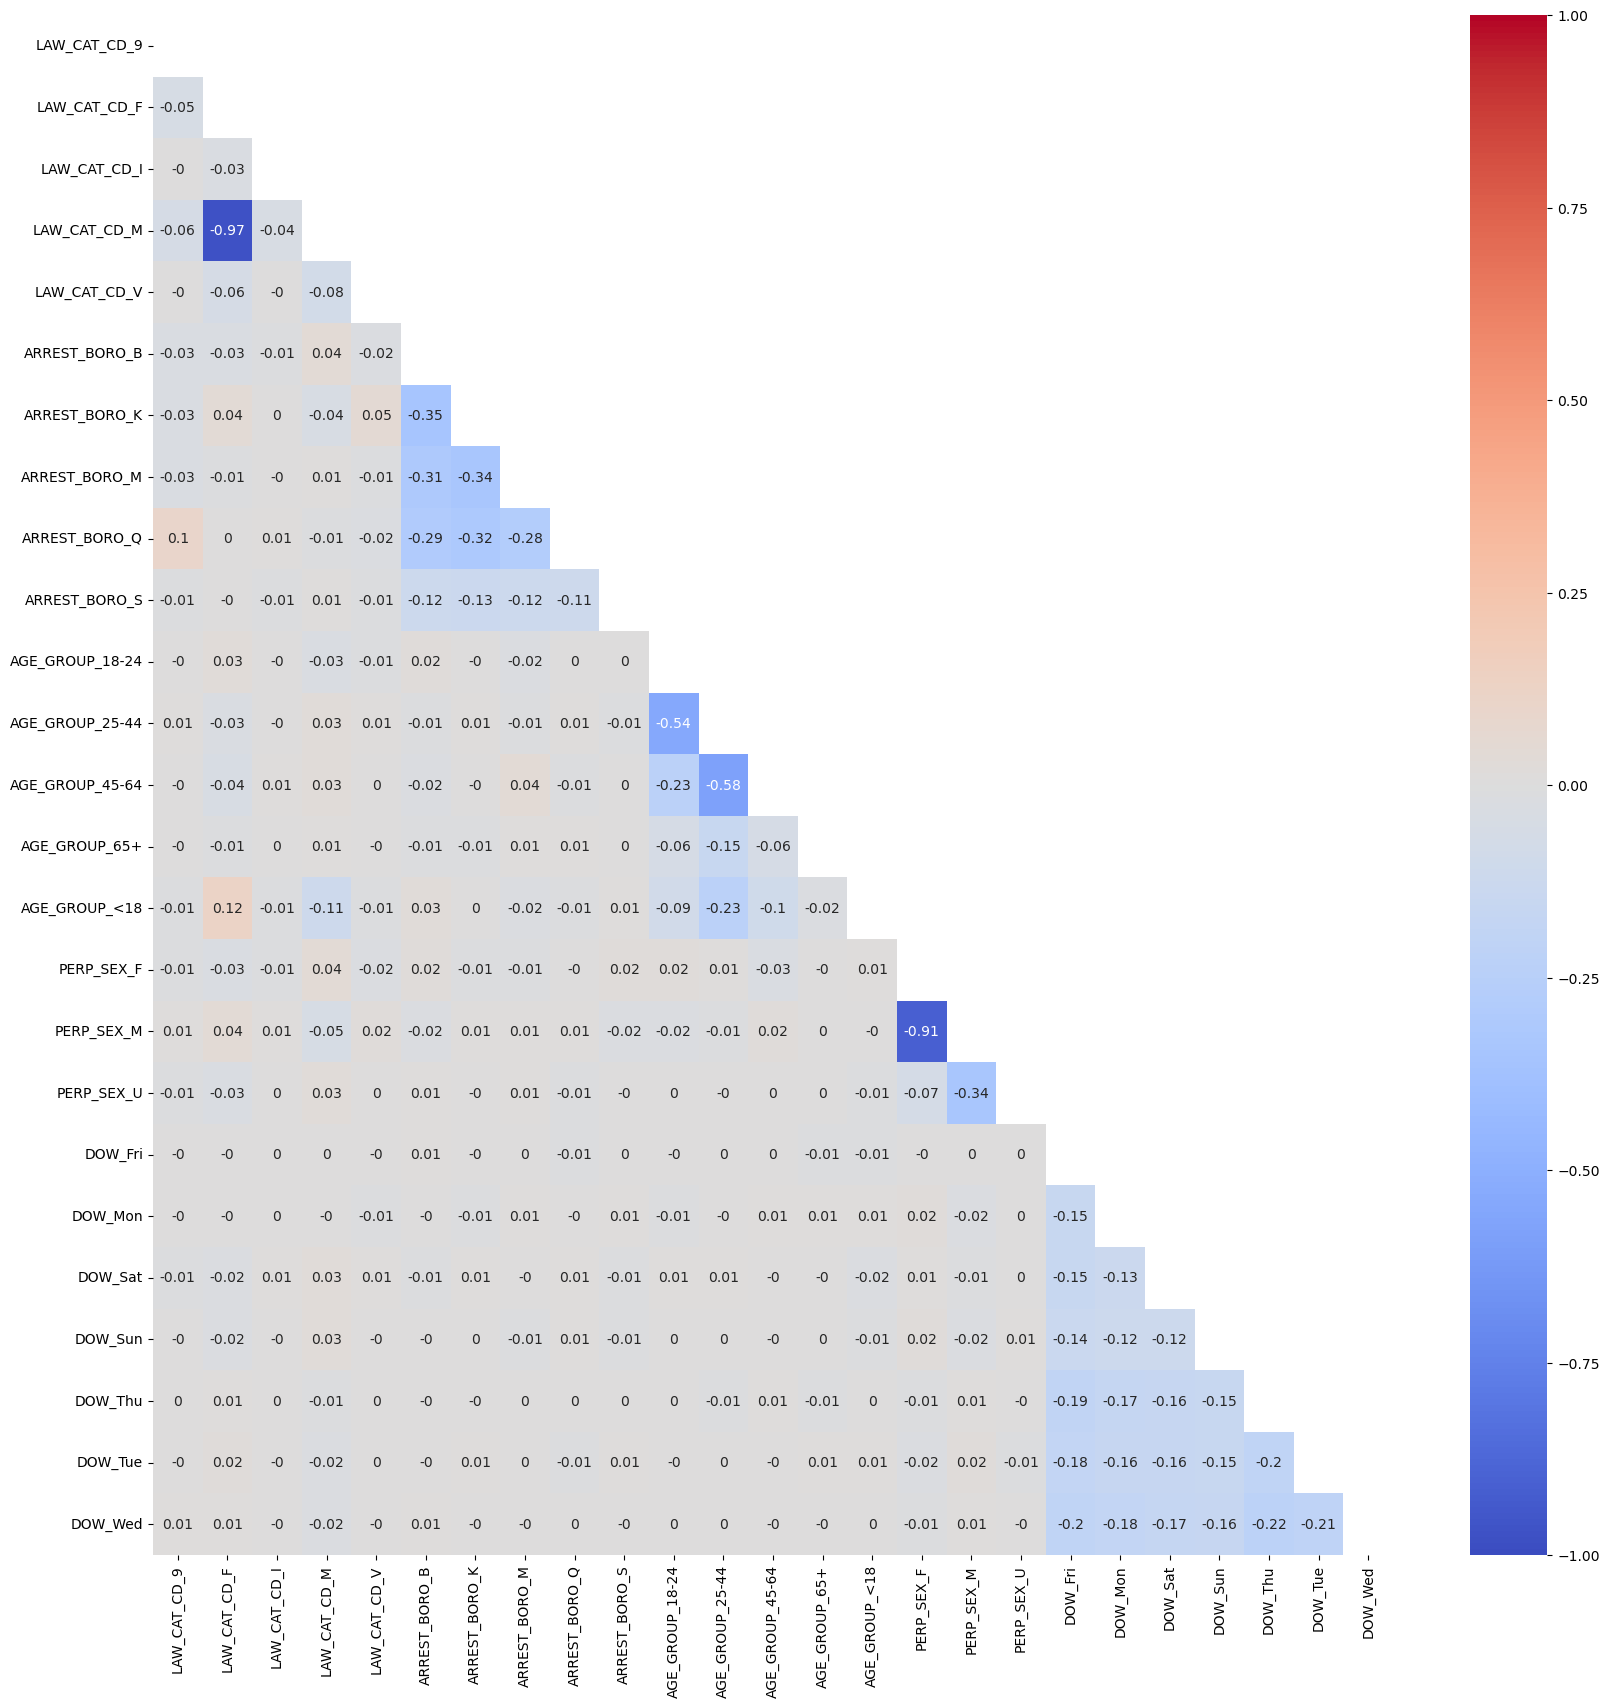

In [40]:
# Looking at collinearity

corrDf = X.corr()
mask = np.triu(corrDf)

plt.figure(figsize=(20,20))
sns.heatmap(corrDf.round(2), annot=True, mask=mask, cmap='coolwarm',vmin=-1,vmax=1)

In [43]:
# Running a regression model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# 1. Instantiate model 
logistic_regression_model = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model.fit(X_train, y_train)

# 3. Score on the training data 
print(logistic_regression_model.score(X_train, y_train))

# 4. Score on the testing data
print(logistic_regression_model.score(X_test, y_test))



0.29723727458470284
0.3001998667554963


/Users/abbascauser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
# Now running a decision tree

DT_model = DecisionTreeClassifier(max_depth = 6)
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.2954494980900773
The TEST classification accuracy is:  0.29460359760159893


In [45]:
#Fit to the training data

best_model = None
best_test_acc = -np.inf
depths = []
test_scores = []
train_scores = []

for iterations in [1,2,3,4,5,6,7,8,9,None]:
    DT_model = DecisionTreeClassifier(max_depth=iterations)
    DT_model.fit(X_train, y_train)
    test_acc = DT_model.score(X_test,y_test)
    train_acc = DT_model.score(X_train,y_train)
    
    
    if test_acc > best_test_acc:
        best_model = DT_model,
        best_test_acc = test_acc
        
    depths.append(iterations)
    test_scores.append(test_acc)
    train_scores.append(train_acc)
                             

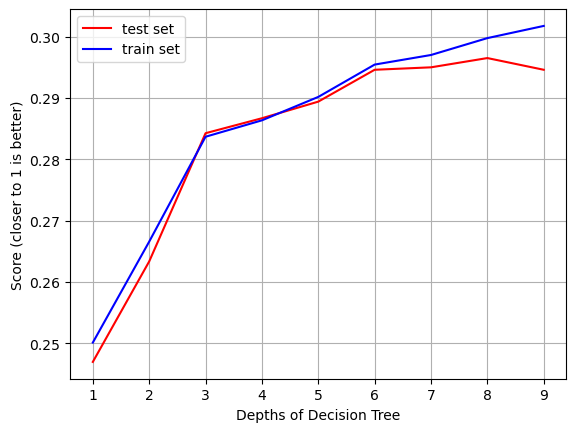

In [46]:
plt.plot(depths, test_scores,  color='red',label="test set")
plt.plot(depths, train_scores,  color='blue',label="train set")
plt.ylabel('Score (closer to 1 is better)')
plt.xlabel('Depths of Decision Tree')
plt.legend()
plt.grid()